In [63]:
import pywikibot
import queue
import gensim
import numpy as np
import warnings
import pickle
warnings.filterwarnings('ignore')  # Suppresses gensim errors
import matplotlib.pyplot as plt
import seaborn as sns
import mwparserfromhell
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
 
from util import get_distance, process_word

In [2]:
# claire's address 
model_addr = '/Users/clairestolz/CS182/CS182-Final-Project/data/GoogleNews-vectors-negative300.bin'

In [351]:
model_gensim = gensim.models.KeyedVectors.load_word2vec_format(model_addr, binary=True)

In [253]:
exclusions = ("Category:", "Wikipedia:", "Help:", "Talk:", "Template:", "Template talk","Portal","File")

def valid_page(title):
    return not title.startswith(exclusions)

In [27]:
site = pywikibot.Site("en", "wikipedia")

In [538]:
# sample list of pages from wikigame pairs 
get_pages = ["Harvard University", "Food and Drug Administration","Brown bear","Osama bin Laden",
            "Ecology","War of 1812","Africa","Planet","Documentary film","Stock market",
            "New York City","Barack Obama", "Nevada","Tobacco", "Masculinity","Transhumanism",
            "Bosnia and Herzegovina","Yellowstone National Park", "Biochemistry","Lactose intolerance",
            "Charles Bronson","Military police","Germany","Sculpture","RNA",
            "Bipolar junction transistor","Web search engine","Crime","Continent","Pneumonia",
            "Mount Olympus","Bank","Cognitive science","Folk music","XML", "New Testament",
            "Ted Kennedy","Aerospace", "Pope","William Shakespeare","Forbes","Solar System", "Heath Ledger",
            "Lost (TV series)","Milky Way","Polish language","Uranus","Far East","Human spaceflight",
            "Magnesium","Soundgarden","Kelly Clarkson","Philosophy","One-child policy","Waffen-SS",
            "Birth","Claire Danes","Hindi","Prefix","Harbor seal", "Carpentry","Serotonin", "Blue",
            "Medicine","Turks and Caicos Islands","Mammal","Literature","French Revolution","Calculus",
            "Iron Age","Gambling","Skin","Babe Ruth","Zheng He","Coffee","Privacy","Advertising",
            "Battle of Midway","Energy","Books of the Bible","Jews","Natural monopoly","Cricket",
            "Electronic circuit","Vaccination","Test pilot","Childbirth","Polar bear","Waterboarding",
            "Entertainment","Open-source software","Unidentified flying object","Malaria","Northern Europe",
            "Volleyball","Morality","Cheese","Silence","Pluto","Rapping","Music","Coffee","Paul McCartney",
            "Fiction","Entertainment","Immunology","Jesus in Christianity","Bewitched","Menopause","FIFA",
            "Cargo ship","Writing system","Cell cycle","Supercomputer","Snake","Bourbon whiskey","Environmentalism",
            "Professional wrestling","European Commission","Taj Mahal","Robert Pattinson","Military",
            "Rush Limbaugh","Recession","Red Dwarf","Taj Mahal","Steven Spielberg", "Typhoid fever",
            "Photosynthesis","Psychologist","SWAT", "Chuck Berry","Giraffe", "Tupac Shakur", "Space Shuttle",
            "East Prussia", "Human evolution","Country","Internet","Greenhouse gas","Britney Spears",
            "Magnesium","Chronic obstructive pulmonary disease", "Sulfur", "Heart", "Hardcore punk",
            "Australasia", "Freemasonry", "Smithsonian Institution","Book", "Chemical element", "Pork",
            "Futurama", "Poverty","Witchcraft","Ear", "Penicillin", "Computer graphics", "Sovereignty","Judo",
            "Company","Western philosophy","Pacific Ocean","Influenza","Illegal drug trade","Electrical conductor",
            "Baptism","Aerosmith","Plate tectonics","Moors", "Psychoactive drug", "Photography", "Occam's razor",
            "Cholesterol", "Milan", "Counterculture of the 1960s", "Airliner", "Southern Ocean","Hunting","Lion",
            "Elton John", "Mass murder", "Peter the Great", "Whale", "The Who", "Protein", "Operating system",
            "Cancer", "Musical instrument", "Cotton", "Classical antiquity", "Horn of Africa", "Eminem",
            "Natural gas","Organization", "Unix", "Citation", "Basketball", "Meat", "Vehicle","House","Dairy",
            "Moon","System"]
get_pages = list(set(get_pages))

In [539]:
# clean page text and return tokens 
def clean_page_text(current_page):
    page_len = len(current_page.text)
    last_char = min(50000,page_len)
    parsed_wikicode = mwparserfromhell.parse(current_page.text[0:last_char])
    text = parsed_wikicode.strip_code()
    test = re.sub(r'([^\s\w]|_)+', '', text)

    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(test.lower())
    stemmer = SnowballStemmer('english')

    unique_tokens = set([])
    for token in tokens:
        unique_tokens.add(stemmer.stem(token))
        
    unique_tokens_no_sw = list(unique_tokens - stop_words)
    
    return unique_tokens_no_sw

In [ ]:
# generate list of page tokens 
page_text = []
pages_scraped = []
for page in get_pages:
    if not page in pages_scraped:
        print(page)
        pages_scraped.append(page)
        current_page = pywikibot.Page(site, page)
        tokens = clean_page_text(current_page)
        page_text.append(tokens)

In [541]:
print(len(pages_scraped))

200


In [591]:
# used to store results from different cluster number tests 
#score_list= []

# saved results from previous runs 
score_list = [(2, 0.56825453),
 (3, 0.564014),
 (4, 0.506467),
 (5, 0.51627827),
 (6, 0.5086251),
 (7, 0.486121),
 (8, 0.49793372),
 (9, 0.5030352),
 (10, 0.48802316),
 (11, 0.4900227),
 (12, 0.50914437),
 (13, 0.48070034),
 (14, 0.47056487),
 (15, 0.43474066),
 (16, 0.45277375),
 (17, 0.4554254),
 (18, 0.43966892),
 (19, 0.45745218),
 (20, 0.40548176)]

In [558]:
# training data

# vectorize word 
model_pages = Word2Vec(page_text, min_count=1)
 
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw
  
X=[]
for page in page_text:
    X.append(sent_vectorizer(page, model_pages))   

print ("========================")
  
NUM_CLUSTERS=12
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.euclidean_distance,
                             repeats=50, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
for i in range(NUM_CLUSTERS):
    print(i,":")
    for j, val in enumerate(assigned_clusters):
        if val == i:
            print(get_pages[j])

silhouette_score = metrics.silhouette_score(X, assigned_clusters, metric='euclidean')
  
print ("Silhouette_score: ")
print (silhouette_score)
#score_list.append((NUM_CLUSTERS,silhouette_score))

0 :
East Prussia
Charles Bronson
1 :
Airliner
Classical antiquity
Horn of Africa
Moors
Sulfur
Pork
Africa
Mount Olympus
Sculpture
Waffen-SS
Babe Ruth
Zheng He
Peter the Great
2 :
Hardcore punk
Philosophy
Bewitched
Hunting
Psychoactive drug
Iron Age
French Revolution
Snake
Robert Pattinson
Ted Kennedy
Elton John
Bosnia and Herzegovina
Documentary film
Polish language
Milan
Jesus in Christianity
Magnesium
The Who
Claire Danes
3 :
Baptism
William Shakespeare
Rapping
Germany
Supercomputer
Eminem
Serotonin
Pope
Environmentalism
Witchcraft
Steven Spielberg
Protein
Judo
Blue
Chuck Berry
Kelly Clarkson
Books of the Bible
Western philosophy
Taj Mahal
Pacific Ocean
Tobacco
Folk music
Military police
Biochemistry
Brown bear
4 :
RNA
Meat
Uranus
Photography
Cheese
Giraffe
Coffee
Nevada
Human spaceflight
Ear
Whale
Mammal
Transhumanism
Hindi
Vehicle
Musical instrument
Turks and Caicos Islands
Battle of Midway
Heath Ledger
Crime
Barack Obama
Soundgarden
Britney Spears
Cholesterol
Book
5 :
Penicillin
B

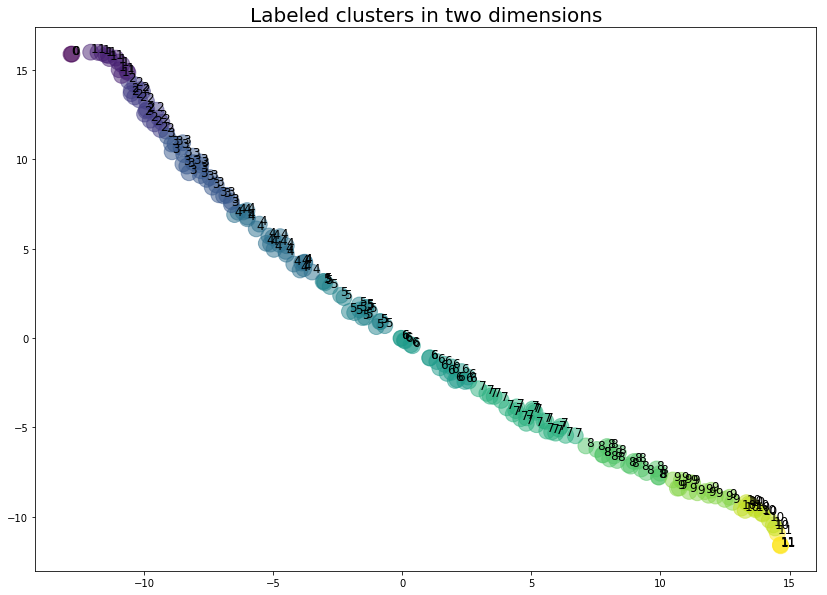

In [576]:
# plot model results in two dimensions 
model_res = TSNE(n_components=2, random_state=0)
 
Y=model_res.fit_transform(X)

plt.figure(figsize=(14,10))
plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=250,alpha=.5)
 
for j in range(len(page_text)):    
    plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points',fontsize=12)

plt.title("Labeled clusters in two dimensions", fontsize=20);
plt.savefig('2Dclusters.png')

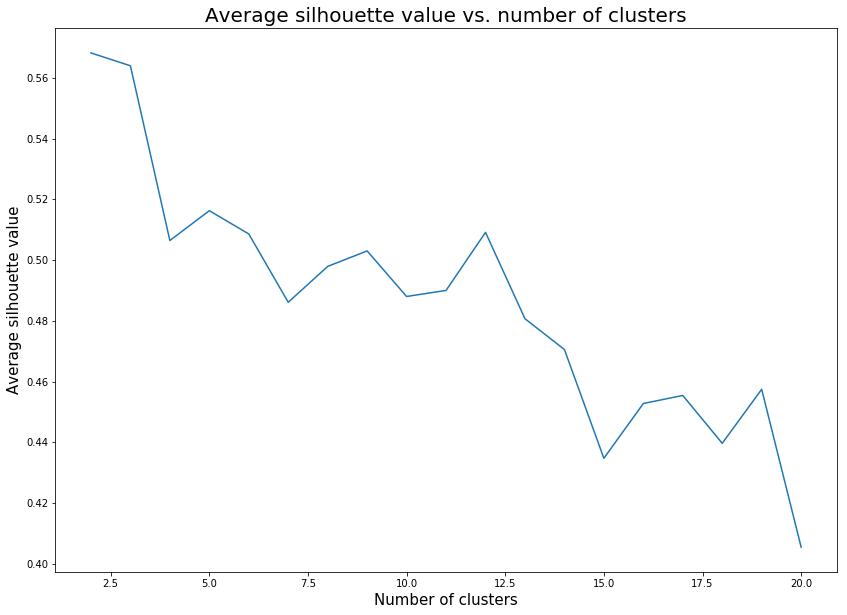

In [592]:
# plot sihouette values vs. num clusters - need to run above code 
# for each cluster # and store in score list to regenerate plot data

num_k = [score_list[i][0] for i in range(len(score_list))]
val_k = [score_list[i][1] for i in range(len(score_list))]

plt.figure(figsize=(14,10))
plt.title("Average silhouette value vs. number of clusters", fontsize=20)
plt.xlabel("Number of clusters", fontsize=15)
plt.ylabel("Average silhouette value", fontsize=15)
plt.plot(num_k,val_k);
plt.savefig('avg_silhouette.png')

In [578]:
# assigned cluster text
cluster_text_list = []
for i in range(NUM_CLUSTERS):
    cluster_text = []
    for j,page in enumerate(get_pages):
        if assigned_clusters[j]==i:
            cluster_text += page_text[j][0:100]
    cluster_text_list.append(cluster_text)

In [579]:
# adaptation of Ben's process word for strings that are pre-split 
def process_word2(topic, model, combine_phrases=True):
    #print(topic[0:5])
    output = []
    words = topic
    if combine_phrases:
        #Iteratively search word2vec for shorter and shorter phrases
        for j in range(len(words), 1, -1):
            test = '_'.join(words[:j])
            if test in model:
                return [test] + process_word(' '.join(words[j:]), model, combine_phrases)

    if words[0] in model:
        output.append(words[0])
    return output + process_word(' '.join(words[1:]), model, combine_phrases)

In [580]:
# process cluster wordlists 
processed_clusters = [process_word2(cluster_text_list[i], 
                                    model_gensim, combine_phrases=True) for i in range(NUM_CLUSTERS)]

In [582]:
# get combined text of clustered pages

# function that returns distance from a cluster
def dist_to_cluster(cluster_int, text):  
    return get_distance(process_word2(text,model_gensim,combine_phrases=True), 
                        model_gensim, processed_clusters[cluster_int], option="combined")

In [ ]:
# function returns closest cluster to text
def clostest_cluster(text):
    min_i = None
    min_dist = float('inf')
    for i in range(NUM_CLUSTERS):
        dist = dist_to_cluster(i,text) 
        print("i",i,"dist",dist)
        if dist<min_dist:
            min_dist = dist
            min_i = i
    return(min_i)

In [583]:
# greedy word2vec using kmeans heuristic
def greedy_word2vec_kmeans(start, goal, maxIters=30, verbose=False, distance_metric="average", combine_phrases=True):
    start_list = process_word(start, model_gensim, combine_phrases)
    goal_list = process_word(goal, model_gensim, combine_phrases)
    
    clean_goal_text = clean_page_text(pywikibot.Page(site, goal))
    print(type(clean_goal_text))
    print(clean_goal_text[0:10])
    closest_cluster_goal = clostest_cluster(clean_goal_text)
    text_cluster_for_search = processed_clusters[closest_cluster_goal]
    
    start_page = pywikibot.Page(site, start)
    path = []
    visited = []
    fringe = queue.PriorityQueue()
    fringe.put((np.Inf, start_page))
    
    i = 0
    while i < maxIters and not fringe.empty():
        print(i)
        i += 1
        priority, page = fringe.get()
        path.append(page.title())
        if verbose:
            print("Exploring node {} with distance {}".format(page.title(), priority))
        if goal.lower() == page.title().lower():
            return path

        for p in page.linkedPages():
            if p.title() not in visited and valid_page(p.title()):
                print(p.title())
                visited.append(p.title())
                processed = process_word(p.title(), model_gensim, combine_phrases)
                distance = get_distance(processed, model_gensim, text_cluster_for_search, distance_metric)
                fringe.put((distance, p))

    return []

In [584]:
greedy_word2vec_kmeans("Newspaper","United States")

<class 'list'>
['scotchirish', 'mississippian', '38', 'georg', 'collect', 'men', 'form', 'act', '1996', 'protect']
i 0 dist 0.9161985897873318
i 1 dist 0.9203269166542173
i 2 dist 0.9199654993184161
i 3 dist 0.9196183552229786
i 4 dist 0.9212067481078894
i 5 dist 0.9192926651907991
i 6 dist 0.9209919169998133
i 7 dist 0.9198345474309763
i 8 dist 0.9198270440197616
i 9 dist 0.9196810119894416
i 10 dist 0.9221724163189113
i 11 dist 0.9179120549423514
0
A Gazeta da Restauração
Diário do Rio de Janeiro
Kevin Barnhurst (media studies scholar)
Nicholas Bourne (publisher)
Notizie scritte
The Princely State
Thomas Archer (publisher)
Timotheus Ritzsch
Acta Diurna
Advertising
Advertising-free media
Advertorial
Advice column
Advocacy journalism
Agah Efendi
Ageing of newspaper readership
Agence France-Presse
Alex Jones (journalist)
Alliance for Audited Media
Alternative media
Amsterdam
Analytic journalism
Ancient Rome
Arabian Peninsula
Arabic
Architecture
Argentina
Argumenty i Fakty
Armistice Day


Émile de Girardin
İbrahim Şinasi
1
Figli d'Italia
1934 Montreux Fascist conference
4th of August Regime
6 February 1934 crisis
Abba Ahimeir
Accessory (legal term)
Acerbo Law
Actual idealism
Adolf Eichmann
Adolf Hitler
Adolf Hitler's rise to power
Afrikaner Weerstandsbeweging
Agostino Lanzillo
Ahnenerbe
Ailtirí na hAiséirghe
Albanian Fascist Militia
Albanian Fascist Party
Albert Forster
Albert Speer
Alfred Ploetz
Alfred Rosenberg
Alfredo Rocco
Allach (porcelain)
Alphonse de Châteaubriant
Alt-right
Amt Rosenberg
Anastasy Vonsiatsky
Ante Pavelić
Anti-Comintern Pact
Anti-Nazi League
Anti-communism
Anti-fascism
Anticlericalism
Antisemitism
Anton Drexler
Arbeitertum
Ardengo Soffici
Arditi
Arrow Cross Party
Art of the Third Reich
Arthur Seyss-Inquart
Artificial insemination
Artur Axmann
Austrian National Socialism
Austrofascism
Authoritarianism
Aventine Secession (20th century)
Axis powers
Baldur von Schirach
Beer Hall Putsch
Benito Mussolini
Berlin Olympic Games
Bernhard Rust
Black Brigades


Thule Society
Totalitarianism
Triumph of the Will
Tōhōkai
Ugo Spirito
Union of Bulgarian National Legions
Union of Fascist Little Ones
Union of Young Fascists – Vanguard (boys)
Union of Young Fascists – Vanguard (girls)
Unite Against Fascism
Ustaše
Vidkun Quisling
Vihtori Kosola
Vlaams Nationaal Verbond
Vlajka
Völkisch
Völkisch movement
Völkischer Beobachter
Waffen-SS
Walther Funk
Weimar Republic
Werwolf
Wilhelm Frick
William Dudley Pelley
Women in Nazi Germany
Yugoslav National Movement
Zoltán Böszörmény
Zweites Buch
2
Agrarianism
Aiséirí
All-for-Ireland League
All Ireland Anti-Partition League
Aontacht Éireann
Boydell Press
Breandán Ó hEithir
Brian Cleeve
British and Irish Communist Organisation
Business and Professional Group
Catholic Union
Centre-left politics
Christian Centrist Party
Christian Solidarity Party
Christian right
Clann na Poblachta
Clann na Talmhan
Clann Éireann
Communism
Communist Party of Ireland (Marxist–Leninist)
Cork Civic Party
Cork Socialist Party
Cumann Poblac

De facto
Death marches (Holocaust)
Death of Adolf Hitler
Democide
Deutsche Ausrüstungswerke
Deutsche Erd- und Steinwerke
Deutsche Wirtschaftsbetriebe
Dieppe Raid
Dorohoi pogrom
Drancy internment camp
Drobytsky Yar
Drohobycz Ghetto
Dunkirk
Działdowo
Dünamünde Action
Earl F. Ziemke
Early timeline of Nazism
Eastern Front (World War II)
Edgar Feuchtinger
Eduard Strauch
Eduard Wirths
Einsatzgruppe
Einsatzgruppen reports
Einsatzgruppen trial
Einsatzkommando
Emil Haussmann
End of World War II in Europe
English Channel
Erhard Heiden
Erhardt Naval Brigade
Eric A. Johnson
Eric Lichtblau
Erich Ehrlinger
Erich Ludendorff
Erich Naumann
Erich von dem Bach
Erich von dem Bach-Zelewski
Ernst Biberstein
Ernst Hermann Himmler
Erwin Rommel
Erwin Schulz
Esoteric
Estonia
Estonian Auxiliary Police
Estonian Legion
Eugen Steimle
Extermination camp
Extermination through labor
Extermination through labour
Falaise Pocket
Falk Zipperer
Far-right politics
Federal Ministry of the Interior (Germany)
Fedor von Bock
Fe

Reich Association of Jews in Germany
Reich Central Office for the Combating of Homosexuality and Abortion
Reich Chancellery
Reich Commissioner for the Consolidation of German Nationhood
Reich Labour Service
Reich Main Security Office
Reichsführer-SS
Reichsmark
Reichssicherheitsdienst
Religion in Nazi Germany
Religious aspects of Nazism
Reparations Agreement between Israel and West Germany
Rescue of the Danish Jews
Rescuers of Jews during the Holocaust
Responsibility for the Holocaust
Rhine
Richard Bessel
Richard Glücks
Richard Hildebrandt
Richard J. Evans
Richard Rhodes
Richard Wendler
Riga Ghetto
Riga ghetto
Righteous Among the Nations
Risiera di San Sabba
Robert Gellately
Robert Gerwarth
Robert Jay Lifton
Roger Moorhouse
Rollkommando Hamann
SS-Oberabschnitt Fulda-Werra
SS-Oberabschnitt Lothringen-Saarpfalz
SS-Oberabschnitt Main
SS-Oberabschnitt Mitte
SS-Oberabschnitt Nord
SS-Oberabschnitt Nordost
SS-Oberabschnitt Nordsee
SS-Oberabschnitt Ost
SS-Oberabschnitt Ostsee
SS-Oberabschnitt R

Latvians
Leon Feldhendler
List of Nazi-German concentration camps
Lithuanians
Lorenz Hackenholt
Lubartów Ghetto
Lublin Reservation
Ludwig Fischer
Luise Danz
Lyublino, Kaliningrad Oblast
Lębork
Majdanek State Museum
Malken Mierzynek
Malmö
March of the Living
Marek Edelman
Margot Dreschel
Maria Mandl
Massacre of Lwów professors
Max Pauly
Maximilian Grabner
Michał Klepfisz
Miles Lerman
Ministry of Public Security (Poland)
Międzyrzec Podlaski Ghetto
Mordechai Anielewicz
Mordechai Tenenbaum
National Security Corps
Nawcz
Nawitz
Nazi German
Nazi concentration camp badge
Nazi crimes against ethnic Poles
Neufahrwasser
Niskie
Nordic countries
Norwegians
Nowy Sącz Ghetto
Nuremberg Trials
Obrzycko
Operation Reinhard in Kraków
Org. Todt
Orpo battalions
Ostlegionen
Oswald Kaduk
Otto Wächter
POLIN Museum of the History of Polish Jews
Palmiry massacre
Paul-Werner Hoppe
Paweł Frenkiel
Pieter Menten
Pińsk Ghetto
Police, West Pomeranian Voivodeship
Polish Righteous Among the Nations
Polish population tra

II liga
I liga (Poland)
Imperial Russian Army
Indiana
Industrialisation
Iron Age
Iron ore
Israel Philharmonic Orchestra
Italy
Iwo Odrowąż
Jacek Krzynówek
Jacob Frank
Jakub Błaszczykowski
Jalisco
Jan Długosz University
January Uprising
Janusz Iwański
Janusz Sybis
Jasna Góra
Jasna Góra Monastery
Jastrzębie-Zdrój
Jaworzno
Jehovah Witnesses
Jerzy Brzęczek
Jerzy Duda-Gracz
Jerzy Kulej
JewishGen
Judaism
Józef Chełmoński
Kalina Jędrusik
Kalisz
Katowice
Katowice International Airport
Katowice Voivodeship
Kazimierz Pulaski
Kazimierz Pułaski
Kielce
Kielce Voivodeship
Kingdom of Prussia
Kingdom of Saxony
Konopiska
Koszalin
Kraków-Częstochowa Upland
Kraków Army
Kraków Voivodeship
Kraków Voivodeship (14th century – 1795)
Krzysztof Matyjaszczyk
Książ Wielki
Kukiz'15
Köppen climate classification
Kłobuck County
Law and Justice
Left Democratic Alliance
Legnica
Lelów
Lesser Poland
List of cities and towns in Poland
List of twin towns and sister cities in Poland
Lithuania
Loreto (AN)
Lourdes
Lower house

Plan R 4
Pluralism (political philosophy)
Polyneuritis
President of the Storting
Prime Minister of Norway
Prisoner-of-war camp
Provost (religion)
PubMed Identifier
Puppet government
Quantum physics
Quisling
Quisling regime
Ragnarök
Reactionary
Reichskommissar
Rembrandt
Repatriation
Revolutionary Trade Union Opposition
Rolf Wickstrøm
Roubles
Russian Provisional Government
Russian famine of 1921
Russian language
SNAC
Saint Olav
Saint Petersburg
Scorched earth
Senterpartiet
Ship-owner
Skien
Slagelse
Social welfare
Sofia
Soviet Communist Party
Soviet government
Special theory of relativity
Stanford, California
Statspolitiet
Storting
Strømsø
Subversion
Supreme Court of Norway
Sven Arntzen
Telemark
Theory of relativity
Thorbjørn Jagland
Thorvald Aadahl
Tidens Tegn
Torgeir Anderssen-Rysst
Total war
Traitor
Trygve Bratteli
Trøndelag
Ukrainian SSR
University of Illinois Press
University of Oslo
Viggo Hansteen
Villa Grande
Villa Grande (Oslo)
Volga region
Wollert Konow (Prime Minister of Norway)

Walter Devereux, 1st Earl of Essex
Wars of Scottish Independence
Watchtower
Water castle
Water cure (torture)
Western United States
William Quantrill
William Tecumseh Sherman
William the Conqueror
Wire obstacle
Witch tower
Württemberg
Xenophon
Yemen
Yett
YouTube
Yugoslav Wars
12
André Laffargue
Battle of Kyurdamir
10th Battalion, CEF
18th Army (German Empire)
1918 flu pandemic
Abdomen
Acute necrotizing ulcerative gingivitis
Adamello-Presanella
Adrian helmet
Aerial reconnaissance
Aerial warfare
Afghanistan
African theatre of World War I
Aftermath of World War I
Agadir Crisis
Agreement of Saint-Jean-de-Maurienne
Air combat manoeuvring
Air superiority
Air supremacy
Airborne troops
Aleksei Brusilov
All Quiet on the Western Front
Allies of World War I
Alps
American Rifleman
Ancient warfare
Anglo-Egyptian Darfur Expedition
Anti-Serb riots in Sarajevo
Anti-tank
Anti-tank mine
Anti-tank warfare
Anti-war movement
Anti tank gun
Antibiotic
Anzac Cove
Ardennes forest
Armenia
Armenian Genocide
Arme

Military intelligence
Military logistics
Military operation
Military operations in North Africa during World War I
Military organization
Military personnel
Military rank
Military recruitment
Military science
Military specialism
Military supply chain management
Military tactics
Military technology
Military theory
Mills bomb
Minenwerfer
Miners
Mines in the Battle of Messines (1917)
Mines on the Italian Front (World War I)
Mines on the first day of the Somme
Mining (military)
Minor campaigns of 1815
Minsk Protocol
Mobility (military)
Modern warfare
Monastir Offensive
Monopoly (game)
Montese
Morale
Morse code
Mortar (weapon)
Mountain warfare
Mustard gas
NATO
Nagorno-Karabakh conflict
Narrow gauge
National Film Board of Canada
Naval artillery
Naval strategy
Naval warfare
Naval warfare in the Mediterranean during World War I
Naval warfare of World War I
Network-centric warfare
New Year's Day
New Zealand Wars
No-man's land
No man's land
North Sea
Nuclear warfare
Ober Ost
Occupation of German 

Muawiya II
Muhammad III of Córdoba
Muhammad II of Córdoba
Muhammad I of Córdoba
Muhammad Nasiruddin al-Albani
Musa bin Nusayr
Muslim conquest of Egypt
Muslim conquest of Sicily
Muslim conquest of the Levant
Muslim conquest of the Maghreb
New Book of Tang
Nikephoros II Phokas
Nikephoros Phokas the Elder
Occupation of Mecca
Old Book of Tang
Pinyin
Quraysh tribe
Rajab
Rashidun
Rashidun Caliphate
Rashidun caliphate
Rashidun empire
Robert Payne (author)
Romanization of Arabic
Sack of Amorium
Sack of Damietta (853)
Sack of Thessalonica (904)
Sahabah
Sahih Muslim
Sahih al-Bukhari
Saudi Arabia
Sayf al-Dawla
Sea of Marmara
Second Fitna
Shia Islam
Sicily
Siege of Aleppo (637)
Siege of Aleppo (994–995)
Siege of Alexandria (641)
Siege of Antioch (968–969)
Siege of Babylon Fortress
Siege of Chandax
Siege of Constantinople
Siege of Constantinople (674–678)
Siege of Constantinople (717–718)
Siege of Damascus (634)
Siege of Emesa
Siege of Euripos
Siege of Germanicia
Siege of Jerusalem (637)
Siege of K

Zalaháshágy
Zalaigrice
Zalaistvánd
Zalakaros
Zalakomár
Zalaköveskút
Zalalövő
Zalamerenye
Zalaszabar
Zalaszentbalázs
Zalaszentgrót
Zalaszentgyörgy
Zalaszentiván
Zalaszentjakab
Zalaszentlászló
Zalaszentlőrinc
Zalaszentmihály
Zalaszentmárton
Zalaszombatfa
Zalaszántó
Zalasárszeg
Zalatárnok
Zalavár
Zalavég
Zalaújlak
Zebecke
Érd
Óhíd
Újudvar
Čakovec
Module:Location map/data/Europe
Module:Location map/data/Hungary
22
Mass murders in Tykocin
23
1999 Oklahoma tornado outbreak
2017 Shayrat missile strike
2017–18 North Korea crisis
24-hour news cycle
ABC News
ABC News (United States)
AdWeek
All-news radio
American Meteorological Society
Asphyxia
Assassination of John F. Kennedy
Attack on Pearl Harbor
Breakfast television
Breaking news (disambiguation)
Broadband
Broadcast syndication
CBS News
CBS Radio
CNN
Car chase
Communications satellite
Criminal trial
Dayparting
Disc jockey
Doppler weather radar
Entercom
Fox Broadcasting Company
Golden Age of Radio
HLN (TV network)
Helicopter
Hurricane
Hurrica

Friedrich Ebert
Friedrich Meinecke
Fundamental Rights Agency
General Order No. 11 (1862)
Geography of antisemitism
German Jews
German nationalism
Gustav Noske
Götterdämmerung
Hagen (legend)
History of antisemitism
History of antisemitism in the United States
Host desecration
House of Hohenzollern
Hunter (Pierce novel)
Islam and antisemitism
Jew Watch
Jewish Bolshevism
Jewish deicide
Jewish ghettos in Europe
Jewish hat
Jewish history
Jewish lobby
Jewish quota
Jewish refugees
John Roberts (historian)
Judensau
Judenzählung
Judeo-Masonic conspiracy theory
Julius Schnorr von Carolsfeld
Kaiser Wilhelm II
Kingdom of Bulgaria
Kosher tax conspiracy theory
Kurt Eisner
La France juive
Leo Frank
Macedonian front
Matthias Erzberger
Medieval antisemitism
Metapedia
Military dictatorship
Nation of Islam and antisemitism
National Socialist German Workers Party
National Vanguard (publication)
National psychology
National trauma
Neill Malcolm
Neue Freie Presse
Neue Zürcher Zeitung
New antisemitism
Nibelu

[]